# Projeto Adventure Works - Previsão de Demanda dos Produtos por Loja Consumidora

## Introdução e objetivos

A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, a empresa Adventure Works gostaria de ter uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja.

Como o objetivo é realizar a previsão de um número, que é a demanda de produtos, este problema poderia ser considerado ser abordado com modelos de regressão. Contudo, não se trata de um problema de regressão simples, pois a ideia seria prever demanda ao longo do tempo, ou seja, tem-se aplicações de séries temporais.

Para cada produto, em cada loja, em cada província/estado e país, existe uma série temporal diferente. Portanto, observando esta questão de hierarquia (produto, loja, estado , país) pode-se aplicar modelos de séries temporais hierárquicas.

Desta forma, o presente projeto abordará o problema de negócio "previsão de demanda por produto por loja" seguindo duas linhas diferentes:

- Modelos de Séries Temporais Hierárquicas
- Modelo de Regressão

Ao fim, as métricas obtidas com cada um deles serão comparadas.

## Instalando e importando as bibliotecas necessárias

In [173]:
pip install hierarchicalforecast

In [174]:
pip install statsforecast

In [175]:
# libs para conexão a base de dados salva no Big Query da Google
from google.cloud import bigquery
from google.colab import auth

# libs para manipulação dos dados
import pandas as pd
import numpy as np

# libs para plotagem de dados
import seaborn as sns
import matplotlib.pyplot as plt

# libs de séries temporais hierárquicas
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsforecast.models import AutoARIMA, SeasonalNaive
from statsforecast.core import StatsForecast
from hierarchicalforecast.utils import aggregate

# libs de regressão
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb

# libs para avaliação de métricas
from sklearn.metrics import mean_squared_error

# lib utilizada para ignorar warnings ao longo da execução do código
import warnings
warnings.filterwarnings('ignore')

## Definindo as funções de métricas a serem utilizadas no decorrer do projeto

Foram definidas abaixo as funções customizadas para cálculo das métricas, tanto dos modelos de Séries Temporais Hierárquicas, quanto de Regressão.

- MAE = erro médio absoluto, basicamente mede a distância média entre os valores previstos pelo modelo e os valores reais.
- MSE = erro médio quadrático, basicamente é a diferença entre o valor previsto e o valor real, elevando-se o resultado ao quadrado. Da mesma forma que o MAE, quanto maior esta métrica pior será o modelo.
- RMSE = raiz do erro quadrático médio, basicamente é a métrica MSE tirando a sua raiz quadrada. Assim, tem-se um valor de melhor interpretabilidade, corringindo também as unidades deste erro.

In [176]:
# cálculo do mae
def custom_mae(y, y_pred):
    return np.round(np.nanmean(abs(y.values -  y_pred.values)), 2)

# cálculo do mse
def custom_mse(y, y_pred):
    return np.round(mean_squared_error(y.values, y_pred.values), 2)

# cálculo do rmse
def custom_rmse(y, y_pred):
    return np.round( np.sqrt(mean_squared_error(y.values,y_pred.values)), 2)

## Leitura dos dados de interesse no Big Query

Como primeira etapa do projeto, é necessário realizar a leitura dos dados salvos no Big Query. Para tal, precisa-se realizar a autentificação do acesso a conta em que se executa este notebook, de tal forma que Google Colab possa acessar arquivos dentro do Google Cloud.

Isto é realizado a partir do código abaixo.

In [177]:
auth.authenticate_user()

Feito, criou-se um agente para realizar as leituras no BigQuery, informando o nome do projeto,

In [178]:
client = bigquery.Client(project='adw-project-431916')

Passando agora as informações do id do projeto, id do schema e id da tabela que será necessário selecionar,

In [179]:
project_id = 'adw-project-431916'
dataset_id = 'dbt_rodrigoprates_marts'
table_id = 'agg_product_store'

Especificando a consulta SQL que será executa pelo agente, no qual irá selecionar todos os dados presentes dentro da "table_id" especificada acima,

In [180]:
# Query SQL ara carregar os dados da tabela "agg_product_store"
query = f"""
SELECT *
FROM {project_id}.{dataset_id}.{table_id}
"""

Por fim, salvando os resultados da consulta especificada acima dentro de um objeto pandas data frame.

In [181]:
df = client.query(query).to_dataframe()

## Explorando a base de dados

Mostrando as primeiras 5 linhas do Data Frame,

In [182]:
df.head()

,orderdate,store_name,product,province,country,orderqty
0,2011-05-31 00:00:00+00:00,Great Bikes,"Sport-100 Helmet, Red",Wyoming,United States,3
1,2011-05-31 00:00:00+00:00,Bike Dealers Association,"Road-650 Red, 62",New Mexico,United States,3
2,2011-06-22 00:00:00+00:00,Online Sell,"Road-650 Black, 52",Moselle,France,1
3,2011-08-01 00:00:00+00:00,Riders Company,"Road-650 Red, 60",Minnesota,United States,3
4,2011-08-31 00:00:00+00:00,Bike Rims Company,"Road-150 Red, 62",Mississippi,United States,2


Percebe-se então que, dentro da tabela "agg_product_store", presente dentro do schema "dbt_rodrigoprates_marts", salvo dentro do projeto Big Query "adw-project-431916", tem-se informações de data, produtos, lojas, província, país e demanda de cada produto.

Mostrando mais informações a respeito deste Data Frame,

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   orderdate   121317 non-null  datetime64[us, UTC]
 1   store_name  121317 non-null  object             
 2   product     121317 non-null  object             
 3   province    121317 non-null  object             
 4   country     121317 non-null  object             
 5   orderqty    121317 non-null  Int64              
dtypes: Int64(1), datetime64[us, UTC](1), object(4)
memory usage: 5.7+ MB


Analisando-se os dados, o primeiro ponto importante a ser avaliado é que nenhuma das colunas apresenta dados nulos. O Data Frame apresenta 121317 entradas, ou linhas, e todas as colunas tem estas 121317 linhas preechidas com valores não nulos. Esta avaliação é muito importante pois, como a ideia deste projeto é realizar previsões de demanda utilizando modelos de série temporal hierárquica e modelos de regressão, ambas estas famílias de modelos não se comportam bem com dados nulos.

Outro ponto importante se refere aos tipos de dados de cada coluna. Percebe-se que a coluna de data "orderdate" está especificada com o tipo correto de dados (datetime). Porém, esta coluna, além de retornar dados de mês, dia e ano, conforme visto anteriormente, ela também tem os dados de hora, minuto e segundo. Como essas últimas informações não são relevantes para a análise aqui, pois o interesse está no dia em si, optou-se por formatar os dados desta coluna, conforme segue abaixo.

In [184]:
df['orderdate'] = pd.to_datetime(df['orderdate'], format='%Y-%m-%d %H:%M:%S').dt.date

In [185]:
df['orderdate'] = pd.to_datetime(df['orderdate'])

In [186]:
df['orderdate']

,orderdate
0,2011-05-31
1,2011-05-31
2,2011-06-22
3,2011-08-01
4,2011-08-31
...,...
121312,2014-04-25
121313,2014-05-01
121314,2014-05-01
121315,2014-05-06


Feitos estes devidos tratamentos iniciais, verifica-se abaixo a nova "cara" destes dados,

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   orderdate   121317 non-null  datetime64[ns]
 1   store_name  121317 non-null  object        
 2   product     121317 non-null  object        
 3   province    121317 non-null  object        
 4   country     121317 non-null  object        
 5   orderqty    121317 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), object(4)
memory usage: 5.7+ MB


Visualizando agora o gráfico de demandas ao longo do tempo,

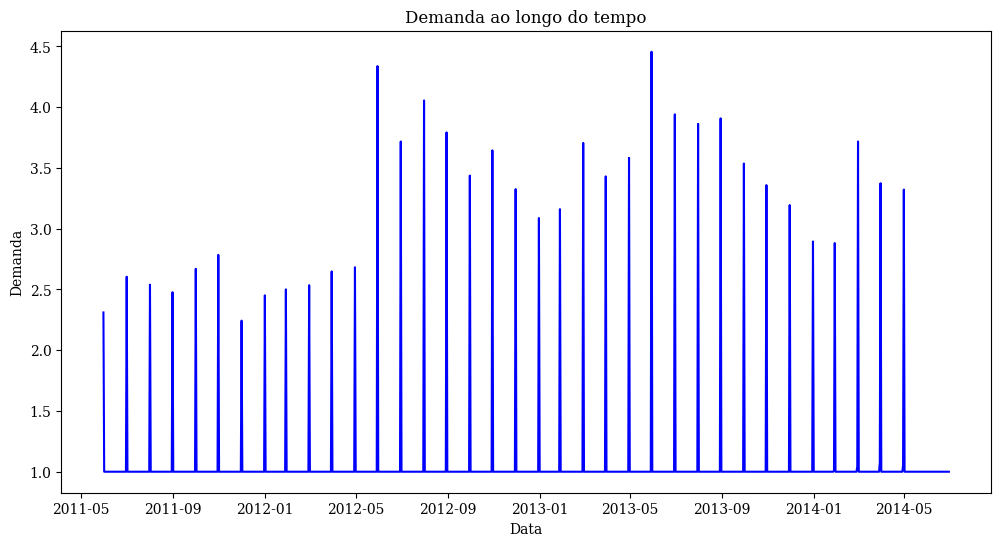

In [189]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = df, x = 'orderdate', y = 'orderqty', color = 'blue', errorbar = None)
plt.title('Demanda ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.show()

Percebe-se que as demandas no gráfico acima estão expostas em dias. Para mostrar estes valores por mês, primeiro é necessário criar uma nova coluna no dataset, de forma a retirar o mês de cada data, conforme demonstrado abaixo,

In [190]:
df['month'] = df['orderdate'].dt.to_period('M').dt.to_timestamp()

In [191]:
df.head()

,orderdate,store_name,product,province,country,orderqty,month
0,2011-05-31,Great Bikes,"Sport-100 Helmet, Red",Wyoming,United States,3,2011-05-01
1,2011-05-31,Bike Dealers Association,"Road-650 Red, 62",New Mexico,United States,3,2011-05-01
2,2011-06-22,Online Sell,"Road-650 Black, 52",Moselle,France,1,2011-06-01
3,2011-08-01,Riders Company,"Road-650 Red, 60",Minnesota,United States,3,2011-08-01
4,2011-08-31,Bike Rims Company,"Road-150 Red, 62",Mississippi,United States,2,2011-08-01


Agrupando agora as demandas por mês,

In [192]:
monthy_demand = (
    df.groupby('month')['orderqty']
    .sum()
    .reset_index()
)

monthy_demand.head(10)

,month,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157
5,2011-10-01,5382
6,2011-11-01,230
7,2011-12-01,1040
8,2012-01-01,3967
9,2012-02-01,1442


Plotando novamente o gráfico,

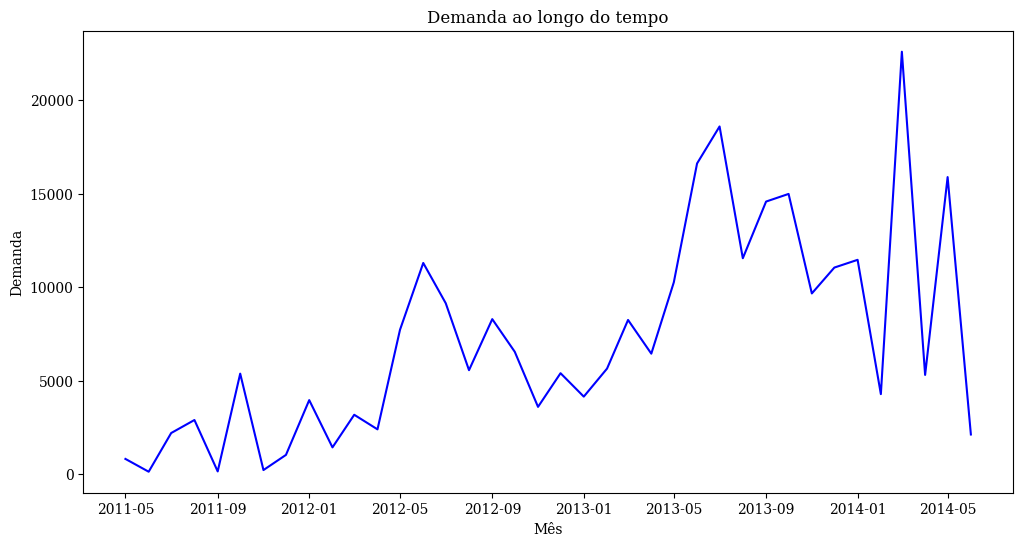

In [193]:
plt.figure(figsize=(12, 6))
sns.lineplot(data = monthy_demand, x='month', y='orderqty', color='blue', errorbar = None)
plt.title('Demanda ao longo do tempo')
plt.xlabel('Mês')
plt.ylabel('Demanda')
plt.show()

Realizando-se agora uma decomposição desta série agrupada mensalmente, com o intuito de avaliar sazonalidade, tendência e resíduos.

In [194]:
result = seasonal_decompose(monthy_demand.set_index('month')['orderqty'], model='additive', period = 12)

Plotando-se os gráficos abaixo das decomposições realizadas. Para tal, definiu-se uma função para exibir cada um dos 4 gráficos e uma única figura.

In [195]:
def plot_decomposition(data: pd.DataFrame, result: DecomposeResult):

    plt.figure(figsize=(12, 8))

    # Plotando a série temporal agrupada por mês sem nenhum tipo de decomposição
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label = 'Original')
    plt.legend(loc='upper left')

    # Plotando o gráfico de Tendência da série temporal
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', color = 'orange')
    plt.legend(loc='upper left')

    # Plotando o gráfico de Sazonalidade da série temporal
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal', color = 'green')
    plt.legend(loc='upper left')

    # Plotando o gráfico de Resíduos da série temporal
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual', color = 'red')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

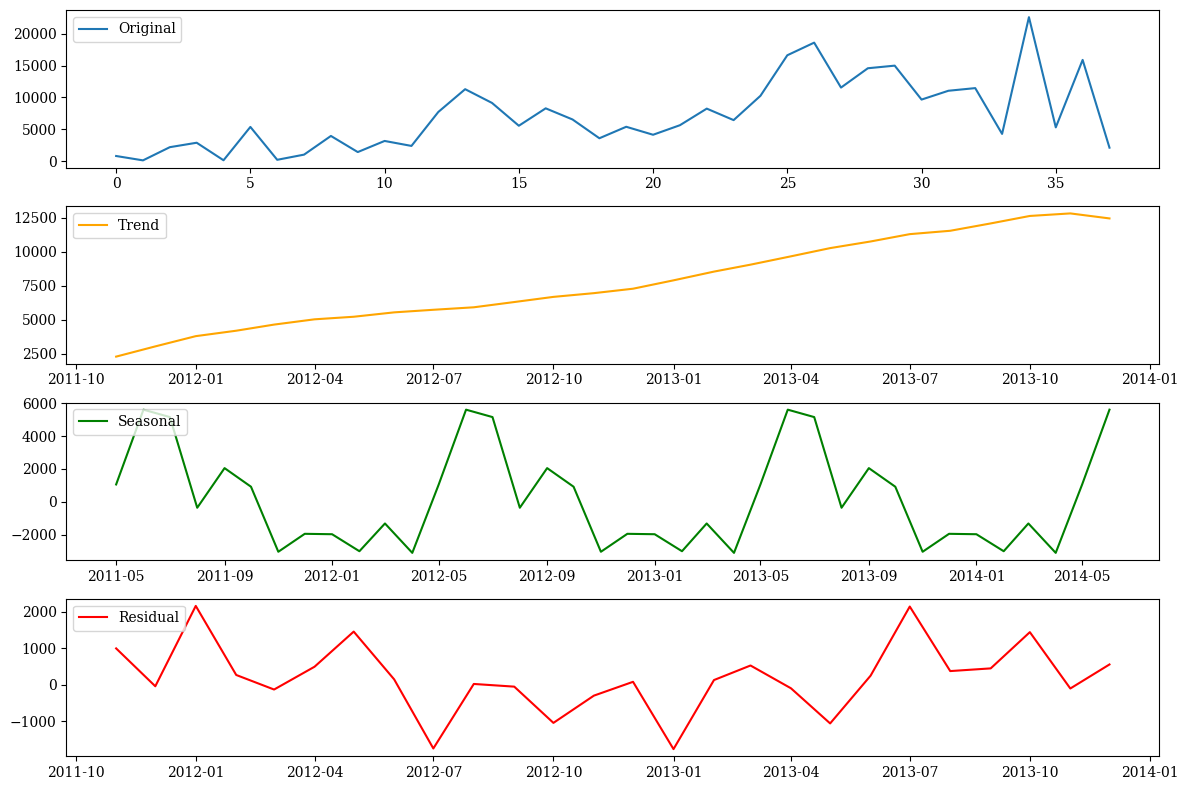

In [196]:
plot_decomposition(data = monthy_demand, result = result)

Observando os resultados acima, é possível notar alguns pontos:

* Como demonstra o gráfico em laranja, existe uma tendência de aumento da demanda de produtos pelas lojas ao passar do tempo.
* Pelo gráfico em verde, percebe-se uma tendência sazonal de aproximadamente 1 ano, com repetição dos comportamentos de demanda, principalmente do mês de setembro de 2011 em diante.
* Já o gráfico de resíduos não nos diz muita coisa, com um comportamento randômico ao longo do tempo.



## Previsão de demanda utilizando modelos de Série Temporal Hierárquica

Considerando o objetivo do projeto, que é prever a demanda por produto para cada loja, a primeira abordagem de modelagem testada foi utilizando a aplicação de séries temporais.

Para tal, primeiro agregou-se a soma das demandas por mês, produto, país, província e loja, conforme demonstrado abaixo.

In [197]:
hts = (
    df.groupby(['month', 'product', 'country', 'province', 'store_name'])['orderqty']
    .sum()
    .reset_index()
)

hts.head()

,month,product,country,province,store_name,orderqty
0,2011-05-01,AWC Logo Cap,Canada,British Columbia,Retail Mall,4
1,2011-05-01,AWC Logo Cap,Canada,Ontario,Original Bicycle Supply Company,4
2,2011-05-01,AWC Logo Cap,Canada,Quebec,Superb Sales and Repair,5
3,2011-05-01,AWC Logo Cap,United States,California,Area Bike Accessories,3
4,2011-05-01,AWC Logo Cap,United States,California,Separate Parts Corporation,3


Definindo agora as hierarquias adotadas. Em um nível mais alto, considerou-se as previsões para os países, em seguida províncias, lojas e por último produtos.

In [198]:
hierarchies = [
    ['country'],
    ['province'],
    ['country', 'province'],
    ['country', 'province', 'store_name'],
    ['country', 'province', 'store_name', 'product']
]

Observação importante: para a utilização das bibliotecas hierarchicalforescast e statsforecast, é necessário renomear as colunas de data para 'ds' e a coluna a ser prevista para 'y', conforme demonstrado a seguir.

In [199]:
hts = hts.rename(columns={'month': 'ds', 'orderqty': 'y'})

Agora, antes da definição e aplicação dos modelos, é necessário agregar os dados conforme a hierarquia definida anteriormente. Para tal, utilizou-se da função aggregate() da biblioteca hierarchicalforecast.

In [200]:
Y_df, S_df, tags = aggregate(hts, hierarchies)
Y_df = Y_df.reset_index()
Y_df

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,61
2,Australia,2011-07-01,68
3,Australia,2011-08-01,53
4,Australia,2011-09-01,64
...,...,...,...
86448,United States/Wyoming/Some Discount Store/Moun...,2011-10-01,2
86449,United States/Wyoming/Some Discount Store/Moun...,2012-01-01,2
86450,United States/Wyoming/Some Discount Store/Moun...,2012-12-01,1
86451,United States/Wyoming/Some Discount Store/Wome...,2013-09-01,1


Observa-se que existem unique_id a nível de país, país/estado, país/estado/loja e país/estado/loja/produto, conforme determinado anteriormente. Explorando-se mais os dados desta coluna,

In [201]:
Y_df['unique_id'].value_counts()

,count
unique_id,
Australia,38
New South Wales,38
United States/California/Online Sell,38
Canada/British Columbia/Online Sell,38
Canada,38
...,...
"Germany/Saarland/Online Sell/Touring-3000 Blue, 50",1
"Germany/Saarland/Online Sell/Touring-3000 Blue, 58",1
"United States/Ohio/Bike Boutique/Road-350-W Yellow, 44",1


In [202]:
Y_df['unique_id'].value_counts().describe()

,count
count,24440.000000
mean,3.537357
std,3.376433
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,38.000000


Observa-se que pelo menos 50% dos dados apresentam-se somente uma ocorrência no dataset. Ou seja, considerando a hierarquia definida anteriormente, existem mais de 12 mil linhas, ou combinações, dentro do dataset que acontecem somente uma vez. Isto pode representar compras esporádicas, produtos que foram comprados em um mês específico, em lojas, e/ou estados, e/ou países específicos.

Este fenômeno, além de ser de difícil previsão, afeta as frequência de ocorrência que os modelos de séries temporais precisam captar ao avaliar e treinar com os dados. Desta forma, dependendo da forma como são dividos os dados, o modelo pode treinar com um dataset sem estas ocorrências específicas e no momento de teste/validação, aparecerem estes casos.

Logo, para fins de solução deste projeto, optou-se por selecionar apenas os casos com ocorrência de ao menos 5 vezes na hierarquia determinada.

Assim, filtrou-se abaixo o data frame utilizando esta condição,

In [203]:
counts = Y_df['unique_id'].value_counts()
Y_df = Y_df[Y_df['unique_id'].isin(counts[counts > 5].index)]

Partindo agora para a divisão dos dados, selecionou-se para teste os últimos 3 meses registrados nos dados.

In [204]:
Y_test_df = Y_df.groupby('unique_id').tail(3)
Y_train_df = Y_df.drop(Y_test_df.index)

### Treinando o modelo e previsão de demanda para os próximos 3 meses

Feito a divisão em bases de treino e teste, partiu-se para o treinamento dos modelos. Neste projeto, optou-se pela utilização de dois modelos: AutoARIMA e SeasonalNaive. Ambos foram declarados dentro do objeto sf, conforme demonstrado abaixo, com frequência de previsão mensal "MS", pois os dados foram agregados por mês.

In [205]:
sf = StatsForecast(
    df = Y_train_df,
    models = [
        AutoARIMA(),
        SeasonalNaive(season_length=12)
    ],
    freq = 'MS',
    n_jobs = -1
)

Definido o objeto sf acima, realizou-se o treinamento e previsão para os próximos 3 meses (h = 3), conforme demonstrado abaixo.

In [206]:
Y_hat_df = sf.forecast(h = 3)

Com o dataset resultante, realizou-se um join entre este dataset e o dataset de teste, de forma a posteriormente serem avaliados.

In [207]:
Y_merged = pd.merge(left = Y_test_df.set_index('unique_id').reset_index(), right = Y_hat_df.reset_index(), on = ['unique_id', 'ds'])

In [208]:
Y_merged

,unique_id,ds,y,AutoARIMA,SeasonalNaive
0,Australia,2014-04-01,1057,1676.000610,112.0
1,Australia,2014-05-01,2090,1158.793457,251.0
2,Australia,2014-06-01,357,1532.609741,778.0
3,Canada,2014-04-01,649,2172.407715,1405.0
4,Canada,2014-05-01,2673,2172.407715,1719.0
...,...,...,...,...,...
5138,United States/Wyoming/Great Bikes /Mountain-20...,2013-08-01,4,0.000000,7.0
5139,United States/Wyoming/Great Bikes /Mountain-20...,2013-08-01,7,5.957648,11.0
5140,United States/Wyoming/Great Bikes /Mountain-20...,2013-08-01,8,4.841378,8.0
5141,United States/Wyoming/Great Bikes /Sport-100 H...,2012-05-01,4,2.000000,2.0


### Calculando as métricas

Realizadas as previsões com o modelo de série temporal hierárquica definido anteriormente, analisou-se as métricas deles, tanto do AutoARIMA quando do SesonalNaive.

Para tal, definiu-se a função declarada abaixo, de tal forma que ela irá validar, para cada um dos tags definidos anteriormente na hierarquia, a comparação entre o valor real "y" e o valor previsto, conforme o modelo especificado dentro da variável de entrada 'model'.

In [209]:
def metrics_results_hts(Y_merged: pd.DataFrame, model: str) -> pd.DataFrame:

  results = []

  for k in tags.keys():

      rmse = custom_rmse(Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), 'y'], Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), model])
      mse = custom_mse(Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), 'y'], Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), model])
      mae = custom_mae(Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), 'y'], Y_merged.loc[Y_merged['unique_id'].isin(tags[k]), model])

      results.append({'Category': k, 'RMSE': rmse, 'MSE': mse, 'MAE': mae})
      results_df = pd.DataFrame(results)

  return results_df

Calculando os resultados para o modelo AutoARIMA,

In [210]:
results_auto_arima = metrics_results_hts(Y_merged, 'AutoARIMA')
results_auto_arima

,Category,RMSE,MSE,MAE
0,country,2041.05,4165876.13,1456.28
1,province,295.90,87554.26,156.72
2,country/province,295.90,87554.26,156.72
3,country/province/store_name,90.69,8224.38,46.34
4,country/province/store_name/product,4.19,17.60,2.77


Agora os resultados para o modelo SeasonalNaive,

In [211]:
results_seasonal_naive = metrics_results_hts(Y_merged, 'SeasonalNaive')
results_seasonal_naive

,Category,RMSE,MSE,MAE
0,country,2160.45,4667523.61,1389.61
1,province,284.28,80812.83,159.04
2,country/province,284.28,80812.83,159.04
3,country/province/store_name,138.14,19083.96,63.23
4,country/province/store_name/product,5.31,28.24,2.61


Em ambos os casos, percebe-se uma diminuição do erro conforme a granularidade dos aumenta. Isto fica evidente pois, na mais baixa granularidade os dados de demanda a serem previstos também são menores. A demanda de um produto específico, em uma loja específica, em uma província específica de um país específico será menor do que a demanda agrupada para o país todo. Logo, os erros tendem a ser bem menores.

### Analisando a previsão para os últimos 3 meses

Feitas as ponderações das métricas de cada modelo, plotou-se os gráficos com as demandas previstas para cada um deles.

In [212]:
# demanda AutoARIMA
monthly_sales_pred_autoarima = (
    Y_merged
    .groupby("ds")["AutoARIMA"].sum()
    .reset_index()
)

# demanda SeasonalNaive
monthly_sales_pred_seasonalnaive = (
    Y_merged
    .groupby("ds")["SeasonalNaive"].sum()
    .reset_index()
)

# dados reais
monthly_sales_y = (
    Y_merged
    .groupby("ds")["y"].sum()
    .reset_index()
)

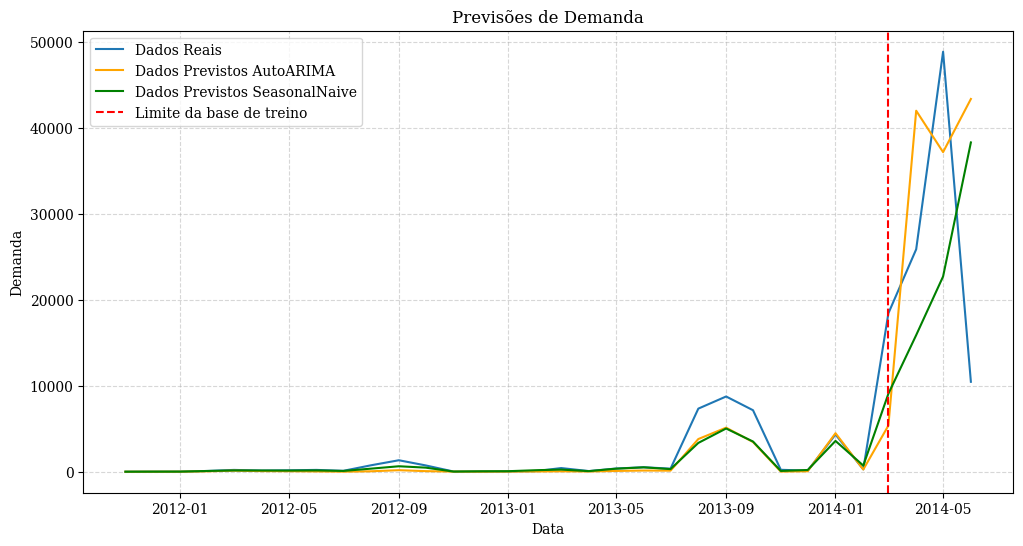

In [213]:
# definindo o tamanho da imagem do gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Dados Reais
df_real = monthly_sales_y.sort_values('ds', ascending=True)
x_real = df_real['ds']
y_real = df_real['y']
plt.plot(x_real, y_real, label = 'Dados Reais')

# Dados Previstos AutoARIMA
df_pred_autoarima = monthly_sales_pred_autoarima.sort_values('ds', ascending=True)
x_pred_autoarima = df_pred_autoarima['ds']
y_pred_autoarima = df_pred_autoarima['AutoARIMA']
plt.plot(x_pred_autoarima, y_pred_autoarima, color = 'orange', label = 'Dados Previstos AutoARIMA')

# Dados Previstos SeasonalNaive
df_pred_seasonalnaive = monthly_sales_pred_seasonalnaive.sort_values('ds', ascending=True)
x_pred_seasonalnaive = df_pred_seasonalnaive['ds']
y_pred_seasonalnaive = df_pred_seasonalnaive['SeasonalNaive']
plt.plot(x_pred_seasonalnaive, y_pred_seasonalnaive, color = 'green', label = 'Dados Previstos SeasonalNaive')

# Limite dos dados presentes na base de treino
limit_date = pd.to_datetime('2014-03-01')
plt.axvline(x = limit_date, color = 'red', linestyle = '--', label = 'Limite da base de treino')

# denominando título, eixo x, eixo y, linhas de grade e legenda
plt.title('Previsões de Demanda')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True, linestyle = '--', alpha=0.5)
plt.show()

Analisando os resultados obtidos acima no gráfico, percebe-se que ambos os modelos treinados consegue captar razoavelmente bem as variações da demanda, considerando a faixa de dados da base de treino.

Agora, quando entra-se na base de teste, percebe-se que o modelo de AutoARIMA capta um pouco melhor as variaçòes, contudo mantendo no geral uma tendência de crescimento. Já o modelo SeasonalNaive segue praticamente uma linear crescente de demanda. Ambos os modelos não conseguem captar de forma eficiente a queda brusca de demanda que ocorre a partir de 05/2014 dos dados reais.

## Modelos de Regressão

Avaliados os modelos de Série Temporal Hierárquica, agora será testado um modelo de regressão propriamente dito. Neste projeto, o modelo de regressão escolhido para ser testado foi o XGBoostRegressor, da biblioteca xgb, importada anteriormente.

Assim, recordando-se a base de dados agrupada,

In [214]:
hts.head()

,ds,product,country,province,store_name,y
0,2011-05-01,AWC Logo Cap,Canada,British Columbia,Retail Mall,4
1,2011-05-01,AWC Logo Cap,Canada,Ontario,Original Bicycle Supply Company,4
2,2011-05-01,AWC Logo Cap,Canada,Quebec,Superb Sales and Repair,5
3,2011-05-01,AWC Logo Cap,United States,California,Area Bike Accessories,3
4,2011-05-01,AWC Logo Cap,United States,California,Separate Parts Corporation,3


### Criando uma coluna com as categorias agrupadas

Para adicionar novas features ao modelo, criou-se uma coluna a mais no dataset, de forma a concatenar todas as hierarquias definidas no modelo de série temporal hierárquica ('product', 'country', 'province', 'store_name').

In [215]:
def concat(row):
    return '/'.join(row)

In [216]:
hts['concatenated'] = hts[['product', 'country', 'province', 'store_name']].apply(concat, axis=1)
hts.head()

,ds,product,country,province,store_name,y,concatenated
0,2011-05-01,AWC Logo Cap,Canada,British Columbia,Retail Mall,4,AWC Logo Cap/Canada/British Columbia/Retail Mall
1,2011-05-01,AWC Logo Cap,Canada,Ontario,Original Bicycle Supply Company,4,AWC Logo Cap/Canada/Ontario/Original Bicycle S...
2,2011-05-01,AWC Logo Cap,Canada,Quebec,Superb Sales and Repair,5,AWC Logo Cap/Canada/Quebec/Superb Sales and Re...
3,2011-05-01,AWC Logo Cap,United States,California,Area Bike Accessories,3,AWC Logo Cap/United States/California/Area Bik...
4,2011-05-01,AWC Logo Cap,United States,California,Separate Parts Corporation,3,AWC Logo Cap/United States/California/Separate...


Definindo a coluna de datas mensais 'ds' como índice do data frame de regressão,

In [217]:
hts = hts.set_index('ds')

Agora, foram criados dois novos data frames, um sem a coluna dos dados concatenados, pois eles serão utilizados posteriormente ao treinamento do modelo de regressão. O outro se trata somente da coluna de dados concatenados, conforme segue,

In [218]:
model_input_reg = hts.drop('concatenated', axis=1)
df_concateneted = hts.loc[:, ['concatenated']]

### Tratando os valores categóricos do data frame

Para rodar-se modelos de regressão, todas as features que apresentam dados categóricos precisam ser tratados de tal forma que estes dados devem ser substituídos por valores numéricos. Isto é necessário pois, modelos de regressão não conseguem tratar de forma adequada features categóricas.

Desta forma, o pré-processador definido para ser utilizado no projeto foi o Ordinal Encoder, da biblioteca Scikitlearn:

- OrdinalEncoder: usado nas features categóricas, este pré-processador basicamente irá substituir as diferentes entradas destas colunas por um número aletório. Diferentemente de outros pré processadores categóricos, como OneHotEncoder por exemplo, não serão criadas nenhuma nova coluna, apenas substituirá as entradas do tipo texto por números.

In [219]:
# definindo o objeto encoder
encoder = OrdinalEncoder()

In [220]:
# tratando as colunas categóricas
model_input_reg['product'] = encoder.fit_transform(model_input_reg[['product']])
model_input_reg['country'] = encoder.fit_transform(model_input_reg[['country']])
model_input_reg['province'] = encoder.fit_transform(model_input_reg[['province']])
model_input_reg['store_name'] = encoder.fit_transform(model_input_reg[['store_name']])

In [221]:
# visualizando os resultados do tratamento
model_input_reg

,product,country,province,store_name,y
ds,,,,,
2011-05-01,0.0,1.0,5.0,446.0,4
2011-05-01,0.0,1.0,44.0,368.0,4
2011-05-01,0.0,1.0,47.0,530.0,5
2011-05-01,0.0,5.0,7.0,22.0,3
2011-05-01,0.0,5.0,7.0,491.0,3
...,...,...,...,...,...
2014-06-01,262.0,3.0,16.0,363.0,1
2014-06-01,262.0,4.0,11.0,363.0,1
2014-06-01,262.0,5.0,7.0,363.0,7


### Divisão dos dados em treinamento e teste

Feito o tratamento, foram divididas as bases de treino e teste do modelo de regressão. Estas bases foram divididas da mesma forma que para os modelos de séries temporais hierárquicas, ou seja, os últimos 3 meses serão para teste e o restante para treino.

In [222]:
# separando as bases
train = model_input_reg.loc[model_input_reg.index < '2014-04-01']
test = model_input_reg.loc[model_input_reg.index >= '2014-04-01']

# definindo a variável "alvo" a ser prevista, ou seja, a demanda
target = 'y'

# definindo as colunas de features de treino e target de treino
X_train = train.drop(columns = target)
y_train = train[target]

# definindo as colunas de features de teste e target de teste
X_test = test.drop(columns = target)
y_test = test[target]

### Treinamento do Modelo

Separadas as bases de treino e teste, o modelo foi definido e treinado, conforme segue abaixo.

In [223]:
# definindo o modelo
reg = xgb.XGBRegressor(base_score = 0.5, max_depth = 3, n_estimators = 1000, learning_rate = 0.01)

In [224]:
# treinando o modelo
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:4.82470	validation_1-rmse:6.54173
[100]	validation_0-rmse:3.83472	validation_1-rmse:5.66577
[200]	validation_0-rmse:3.63474	validation_1-rmse:5.41453
[300]	validation_0-rmse:3.56677	validation_1-rmse:5.29631
[400]	validation_0-rmse:3.53535	validation_1-rmse:5.23719
[500]	validation_0-rmse:3.50592	validation_1-rmse:5.18025
[600]	validation_0-rmse:3.48577	validation_1-rmse:5.14532
[700]	validation_0-rmse:3.46734	validation_1-rmse:5.11550
[800]	validation_0-rmse:3.45168	validation_1-rmse:5.08952
[900]	validation_0-rmse:3.43642	validation_1-rmse:5.06273
[999]	validation_0-rmse:3.42316	validation_1-rmse:5.03971


XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Com o modelo treinado, foram realizadas as previsões para os dados de teste. Estas previsões foram salvas em uma nova coluna 'prediction' dentro da base de teste definida anteriormente.

In [225]:
test['prediction'] = reg.predict(X_test)

Assim, a base de teste fica da seguinte forma,

In [226]:
test

,product,country,province,store_name,y,prediction
ds,,,,,,
2014-04-01,0.0,0.0,38.0,363.0,17,4.869244
2014-04-01,0.0,0.0,48.0,363.0,5,4.259714
2014-04-01,0.0,0.0,55.0,363.0,4,3.420081
2014-04-01,0.0,0.0,58.0,363.0,1,3.420081
2014-04-01,0.0,0.0,64.0,363.0,9,4.275659
...,...,...,...,...,...,...
2014-06-01,262.0,3.0,16.0,363.0,1,5.085087
2014-06-01,262.0,4.0,11.0,363.0,1,6.747622
2014-06-01,262.0,5.0,7.0,363.0,7,8.229268


Adicionando a coluna 'prediction' no Data Frame de input do modelo,

In [227]:
model_input_reg['prediction'] = pd.Series([float('NaN')] * len(model_input_reg), index  =model_input_reg.index)

Agora, adicionando todos os valores previstos nas últimas linhas da coluna 'prediction' criada anteriormente,

In [228]:
qty_predictions = len(test['prediction'].values)
qty_predictions

5979

In [229]:
model_input_reg.iloc[-qty_predictions:, model_input_reg.columns.get_loc('prediction')] = test['prediction'].values
model_input_reg

,product,country,province,store_name,y,prediction
ds,,,,,,
2011-05-01,0.0,1.0,5.0,446.0,4,NaN
2011-05-01,0.0,1.0,44.0,368.0,4,NaN
2011-05-01,0.0,1.0,47.0,530.0,5,NaN
2011-05-01,0.0,5.0,7.0,22.0,3,NaN
2011-05-01,0.0,5.0,7.0,491.0,3,NaN
...,...,...,...,...,...,...
2014-06-01,262.0,3.0,16.0,363.0,1,5.085087
2014-06-01,262.0,4.0,11.0,363.0,1,6.747622
2014-06-01,262.0,5.0,7.0,363.0,7,8.229268


#### Métricas do modelo

Com as previsões de teste realizadas, calculou-se as métricas do modelo de regressão.

In [230]:
rmse = custom_rmse(test['y'], test['prediction'])
mse = custom_mse(test['y'], test['prediction'])
mae = custom_mae(test['y'], test['prediction'])

results_xgboost = {'RMSE': [rmse], 'MSE': [mse], 'MAE': [mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,5.04,25.4,2.53


### Analisando a previsão da demanda dos próximos 3 meses utilizando o modelo regressivo

Visualizando as últimas 10 linhas com os resultados previstos pelo modelo,

In [231]:
model_input_reg.tail(10)

,product,country,province,store_name,y,prediction
ds,,,,,,
2014-06-01,261.0,5.0,45.0,363.0,3,3.174693
2014-06-01,261.0,5.0,66.0,363.0,5,3.660881
2014-06-01,262.0,0.0,64.0,363.0,1,4.307565
2014-06-01,262.0,1.0,5.0,363.0,2,7.992221
2014-06-01,262.0,2.0,40.0,363.0,1,4.939684
2014-06-01,262.0,3.0,16.0,363.0,1,5.085087
2014-06-01,262.0,4.0,11.0,363.0,1,6.747622
2014-06-01,262.0,5.0,7.0,363.0,7,8.229268
2014-06-01,262.0,5.0,45.0,363.0,1,6.003088


Mostrando no gráfico as previsões,

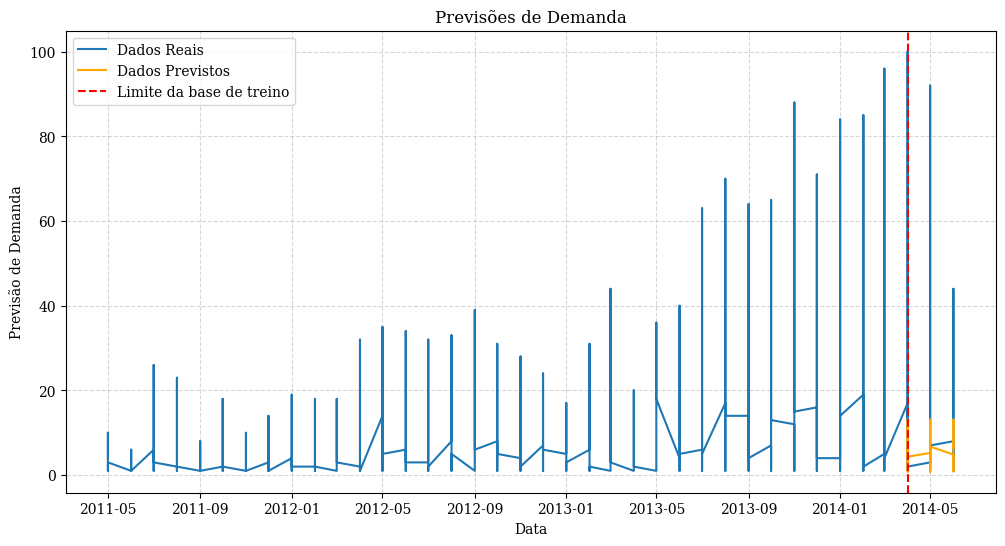

In [232]:
# definindo o tamanho de figura
fig, ax = plt.subplots(figsize = (12, 6))

# dados reais
plt.plot(model_input_reg[['y']], label = 'Dados Reais')

# dados previstos pelo modelo de regressão
plt.plot(model_input_reg['prediction'], color = 'orange', label = 'Dados Previstos')

# limite dos dados presentes na base de treino
limit_date = pd.to_datetime('2014-04-01')
plt.axvline(x = limit_date, color = 'red', linestyle = '--', label = 'Limite da base de treino')

# definindo o título do gráfico, eixo x, eixo y, linhas de grade e legenda
plt.title('Previsões de Demanda')
plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.legend()
plt.grid(True, linestyle = '--', alpha=0.5)
plt.show()

Pelos resultados acima, percebe-se que o modelo de regressão conseguiu captar algumas variações, contudo as oscilações mais bruscas de demanda, a performance não foi tão satisfatório. Uma abordagem que poderia melhorar as performances deste modelo seria buscar otimizações dos seus hiperparâmetros, alinhada a um método de avaliação mais robusto, como a validação cruzada.

Desta forma, poderia-se estudar mais afundo os principais comportamentos deste modelo e entender qual a combinação de hiperparâmetro apresenta o melhor resultado.

## Comparando os resultados das métricas do modelo XGBoost com os modelos de série temporal hierárquica

In [233]:
# métricas do modelo de regressão
results_df_xgboost

,RMSE,MSE,MAE
0,5.04,25.4,2.53


In [234]:
# métricas do modelo de série temporal hierárquica AutoARIMA
results_auto_arima

,Category,RMSE,MSE,MAE
0,country,2041.05,4165876.13,1456.28
1,province,295.90,87554.26,156.72
2,country/province,295.90,87554.26,156.72
3,country/province/store_name,90.69,8224.38,46.34
4,country/province/store_name/product,4.19,17.60,2.77


In [235]:
# métricas do modelo de série temporal hierárquica SeasonalNaive
results_seasonal_naive

,Category,RMSE,MSE,MAE
0,country,2160.45,4667523.61,1389.61
1,province,284.28,80812.83,159.04
2,country/province,284.28,80812.83,159.04
3,country/province/store_name,138.14,19083.96,63.23
4,country/province/store_name/product,5.31,28.24,2.61


Analisando-se os resultados acima, se pegarmos como base o nível mais granular das hierarquias dos modelos de série temporal hierárquica, percebe-se que os 3 modelos testados apresentaram métricas muito parecidas, com poucas variações entre elas.

Contudo, avaliando-se as métricas dos modelos de série temporal de forma agregada, considerando todas as hierarquias,

In [236]:
# Métricas agregadas modelo AutoARIMA
rmse = custom_rmse(y = Y_merged['y'], y_pred = Y_merged['AutoARIMA'])
mse = custom_mse(y = Y_merged['y'], y_pred = Y_merged['AutoARIMA'])
mae = custom_mae(y = Y_merged['y'], y_pred = Y_merged['AutoARIMA'])

print(f'RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}')

RMSE: 143.42, MSE: 20568.20, MAE: 20.45


In [237]:
# Métricas agregadas modelo SeasonalNaive
rmse = custom_rmse(y = Y_merged['y'], y_pred = Y_merged['SeasonalNaive'])
mse = custom_mse(y = Y_merged['y'], y_pred = Y_merged['SeasonalNaive'])
mae = custom_mae(y = Y_merged['y'], y_pred = Y_merged['SeasonalNaive'])

print(f'RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}')

RMSE: 150.67, MSE: 22702.27, MAE: 21.45


Percebe-se que as métricas de ambos os modelos de série temporal hierárquica tiveram RMSE perto dos 150, MSE maior que 20000 e MAE perto de 20. Já o modelo XGBoost teve RMSE = 5.04, MSE = 25.4 e MAE = 2.53.

Desta forma, avaliando no todo, o modelo de regressão apresentou melhores métricas e portanto é o escolhido para avaliar as demandas a seguir por centro de Distribuição.

## Análises dos Centros de Distribuição

Adicionando a coluna com as categorias agregadas no data frame completo com as previsões.

In [238]:
model_input_reg['product/country/province/store_name'] = df_concateneted['concatenated']

Filtrando o dataset, selecionando apenas os dados entre 01-01-2024 e 30-06-2014

In [239]:
# definindo as datas de interesse
start_date= '2014-01-01'
final_date = '2014-06-30'

In [240]:
df_filtered = model_input_reg.loc[start_date:final_date]
df_filtered

,product,country,province,store_name,y,prediction,product/country/province/store_name
ds,,,,,,,
2014-01-01,0.0,0.0,38.0,46.0,4,NaN,AWC Logo Cap/Australia/New South Wales/Bike Pa...
2014-01-01,0.0,0.0,38.0,335.0,16,NaN,AWC Logo Cap/Australia/New South Wales/Nationw...
2014-01-01,0.0,0.0,38.0,363.0,27,NaN,AWC Logo Cap/Australia/New South Wales/Online ...
2014-01-01,0.0,0.0,38.0,388.0,7,NaN,AWC Logo Cap/Australia/New South Wales/Popular...
2014-01-01,0.0,0.0,48.0,363.0,10,NaN,AWC Logo Cap/Australia/Queensland/Online Sell
...,...,...,...,...,...,...,...
2014-06-01,262.0,3.0,16.0,363.0,1,5.085087,"Women's Mountain Shorts, S/Germany/Hamburg/Onl..."
2014-06-01,262.0,4.0,11.0,363.0,1,6.747622,"Women's Mountain Shorts, S/United Kingdom/Engl..."
2014-06-01,262.0,5.0,7.0,363.0,7,8.229268,"Women's Mountain Shorts, S/United States/Calif..."


Selecionando apenas as colunas de interesse para analisar as distribuições,

In [241]:
final_df = df_filtered[['product/country/province/store_name', 'y', 'prediction']]
final_df

,product/country/province/store_name,y,prediction
ds,,,
2014-01-01,AWC Logo Cap/Australia/New South Wales/Bike Pa...,4,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Nationw...,16,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Online ...,27,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Popular...,7,NaN
2014-01-01,AWC Logo Cap/Australia/Queensland/Online Sell,10,NaN
...,...,...,...
2014-06-01,"Women's Mountain Shorts, S/Germany/Hamburg/Onl...",1,5.085087
2014-06-01,"Women's Mountain Shorts, S/United Kingdom/Engl...",1,6.747622
2014-06-01,"Women's Mountain Shorts, S/United States/Calif...",7,8.229268


#### Selecionando os registros dos EUA e dos outros países

In [242]:
# dados dos EUA
df_usa = final_df[final_df['product/country/province/store_name'].str.contains('United States')]

# dados de qualquer outro país que não seja os EUA
df_outside_usa = final_df[~final_df['product/country/province/store_name'].str.contains('United States')]

Para o cálculo de crescimento da demanda, foi definida a seguinte função abaixo, no qual ela irá receber os dados entre 01/01/2024 e 03/01/2014 definidos como os dados da demanda dos 3 meses anterior a previsão. E os dados entre 01/04/2024 e 01/06/2024 foram os dados previstos de demanda para os 3 meses posteriores.

In [243]:
def demand(df:pd.DataFrame) -> dict:

    first_df = df.loc['2014-01-01':'2014-03-01']
    first_demand = first_df['y'].sum()

    last_df = df.loc['2014-04-01':'2014-06-01']
    prediction_demand = last_df['prediction'].sum()

    results = prediction_demand - first_demand

    return {'Demanda Jan a Março 2014': round(first_demand), 'Previsão de Demanda Abril a Junho 2014': round(prediction_demand), 'Crescimento': round(results)}

Assim, calculando a demanda dos centros de distribuição presentes nos EUA,

In [244]:
demand_usa = demand(df_usa)
demand_usa

{'Demanda Jan a Março 2014': 18303,
 'Previsão de Demanda Abril a Junho 2014': 8769,
 'Crescimento': -9534}

Calculando agora a previsão de demandas dos centros de distribuição fora dos EUA,

In [245]:
demand_outside_usa = demand(df_outside_usa)
demand_outside_usa

{'Demanda Jan a Março 2014': 20029,
 'Previsão de Demanda Abril a Junho 2014': 13032,
 'Crescimento': -6997}

Portanto, observa-se uma queda na previsão de demanda para os próximos 3 meses tanto para os centros de distribuição dos EUA, quando para o restante do mundo. Contudo, observa-se que os países fora dos EUA tiveram uma demanda prevista agregada de 13032 produtos, enquanto que dentro dos EUA foi de 8769. Portanto, a demanda fora dos EUA prevista é maior.

## Previsão da quantidade de Zíperes a serem produzidos

Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Para responder isto, sabe-se que são necessários 2 zíperes por par de luva.

Portano, para realizar tal cálculo, é necessário saber da previsão de demanda de luvas para os próximos 3 meses, assim tem-se também a demanda de zíperes.

Logo, primeiro filtrou-se o Data Frame final, de tal forma que foram selecionadas todas as linhas da coluna agregada "product/country/province/store" que apresenta o termo "Gloves" em sua composição.

In [246]:
# selecionando somente os índices das linhas que apresentam a palavra "Gloves" dentro da coluna concatenada "product/country/province/store_name"
gloves_rows = final_df[final_df['product/country/province/store_name'].str.contains('Gloves')].index

In [247]:
# filtrando o data frame final
df_gloves = final_df.loc[gloves_rows]
df_gloves

,product/country/province/store_name,y,prediction
ds,,,
2014-01-01,AWC Logo Cap/Australia/New South Wales/Bike Pa...,4,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Nationw...,16,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Online ...,27,NaN
2014-01-01,AWC Logo Cap/Australia/New South Wales/Popular...,7,NaN
2014-01-01,AWC Logo Cap/Australia/Queensland/Online Sell,10,NaN
...,...,...,...
2014-06-01,"Women's Mountain Shorts, S/Germany/Hamburg/Onl...",1,5.085087
2014-06-01,"Women's Mountain Shorts, S/United Kingdom/Engl...",1,6.747622
2014-06-01,"Women's Mountain Shorts, S/United States/Calif...",7,8.229268


Selecionando somente as datas previstas dos últimos 3 meses,

In [248]:
df_gloves = df_gloves.loc['2014-04-01':'2014-06-30']
df_gloves

,product/country/province/store_name,y,prediction
ds,,,
2014-04-01,AWC Logo Cap/Australia/New South Wales/Online ...,17,4.869244
2014-04-01,AWC Logo Cap/Australia/Queensland/Online Sell,5,4.259714
2014-04-01,AWC Logo Cap/Australia/South Australia/Online ...,4,3.420081
2014-04-01,AWC Logo Cap/Australia/Tasmania/Online Sell,1,3.420081
2014-04-01,AWC Logo Cap/Australia/Victoria/Online Sell,9,4.275659
...,...,...,...
2014-06-01,"Women's Mountain Shorts, S/Germany/Hamburg/Onl...",1,5.085087
2014-06-01,"Women's Mountain Shorts, S/United Kingdom/Engl...",1,6.747622
2014-06-01,"Women's Mountain Shorts, S/United States/Calif...",7,8.229268


Assim, a quantidade total de pares de luvas será,

In [250]:
gloves = df_gloves['prediction'].sum()
pair_of_gloves = round(gloves/2)
pair_of_gloves

878107

Portanto, existe uma demanda de 878107 pares de luvas. Como é necessário 2 zíperes por par, logo

In [252]:
ziper = pair_of_gloves*2
ziper

1756214

Desta forma, a demanda de zíperes é de 1756214.